# 1- Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import html
import sklearn.exceptions
from nltk import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from skopt import BayesSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
% matplotlib inline

# 2- Load data and drop unused column

In [2]:
df_train = pd.read_csv(root + "train.csv", encoding='latin-1', usecols=range(3))
df_test = pd.read_csv(root + "test.csv", encoding='latin-1', usecols=range(2))
df_test.insert(loc=1, column="Sentiment", value=np.nan)
df = df_train.append(df_test, ignore_index=True, sort=False)
df = df.drop(['ItemID'], axis=1)

# 3- Remove duplicates if any and preview the data

In [3]:
print(len(df))
df = df.drop_duplicates()
df.head()

299987


,Sentiment,SentimentText
0,0.0,is so sad for my APL frie...
1,0.0,I missed the New Moon trail...
2,1.0,omg its already 7:30 :O
3,0.0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0.0,i think mi bf is cheating on me!!! ...


# 4- Summarized information of the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299987 entries, 0 to 299986
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Sentiment      99989 non-null   float64
 1   SentimentText  299987 non-null  object 
dtypes: float64(1), object(1)
memory usage: 6.9+ MB


# 5- Check for unique values and normalize if necessary

In [5]:
df.nunique()

Sentiment             2
SentimentText    299987
dtype: int64

# 6- Statistical description of the data 

In [6]:
df.describe()

,Sentiment
count,99989.000000
mean,0.564632
std,0.495808
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


# 7- Visualize the data

## Distribution of the class label with a bar-chart

Text(0, 0.5, 'Number of instances')

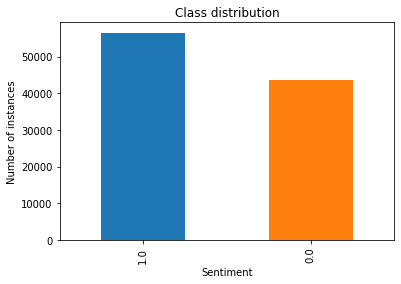

In [7]:
ax = df['Sentiment'].value_counts().plot.bar(title="Class distribution", color=['C0', 'C1'])
ax.set_xlabel("Sentiment")
ax.set_ylabel("Number of instances")

# 8- Feature engineering

## Check missing values in columns

In [8]:
df.isnull().sum()

Sentiment        199998
SentimentText         0
dtype: int64

## Clean the tweets

In [9]:
# Clean a tweet
def function_clean_tweet(text):
    # Escaping HTML characters
    text = html.unescape(text)
    # Removal of URLs
    text = re.sub(r"http\S+", "", text)
    # Removal of mentions
    text = re.sub("@[^\s]*", "", text)
    # Removal of hashtags
    text = re.sub("#[^\s]*", "", text)
    # Removal of numbers
    text = re.sub('[0-9]*[+-:]*[0-9]+', "", text)
    # Convert to lowercase
    text = text.lower()
    # Removal of repeating characters (more than two consecutive characters)
    text = re.sub(r'(.)\1+', r'\1\1', text) 
    # Apostrophe lookup
    text = re.sub("'ll", " will", text)
    text = re.sub("'ve", " have", text)
    text = re.sub("n't", " not", text)
    text = re.sub("'d", " would", text)
    text = re.sub("'re", " are", text)
    text = re.sub("i'm", "i am", text)
    text = re.sub("it's", "it is", text)
    text = re.sub("she's", "she is", text)
    text = re.sub("he's", "he is", text)
    text = re.sub("here's", "here is", text)
    text = re.sub("that's", "that is", text)
    text = re.sub("there's", "there is", text)
    text = re.sub("what's", "what is", text)
    text = re.sub("who's", "who is", text)
    text = re.sub("'s", "", text)
    # Removal of punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Handling slang words
    text = re.sub(r"\btmrw\b", "tomorrow", text)
    text = re.sub(r"\bur\b", "your", text)
    text = re.sub(r"\burs\b", "yours", text)
    text = re.sub(r"\bppl\b", "people", text)
    text = re.sub(r"\byrs\b", "years", text)
    # Handling acronyms
    text = re.sub(r"\b(rt)\b", "retweet", text)
    text = re.sub(r"\b(btw)\b", "by the way", text)
    text = re.sub(r"\b(asap)\b", "as soon as possible", text)
    text = re.sub(r"\b(fyi)\b", "for your information", text)
    text = re.sub(r"\b(tbt)\b", "throwback thursday", text)
    text = re.sub(r"\b(tba)\b", "to be announced", text)
    text = re.sub(r"\b(tbh)\b", "to be honest", text)
    text = re.sub(r"\b(faq)\b", "frequently asked questions", text)
    text = re.sub(r"\b(icymi)\b", "in case you missed it", text)
    text = re.sub(r"\b(aka)\b", "also known as", text)
    text = re.sub(r"\b(ama)\b", "ask me anything", text)
    # Removal of stop words
    stop_words = stopwords.words("english")
    text = " ".join([word for word in text.split() if word not in stop_words])
    # Word stemming
    stemmer = PorterStemmer()
    text = " ".join([stemmer.stem(word) for word in text.split()])
    # Word lemmatization
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [10]:
df['SentimentText'] = df['SentimentText'].apply(lambda text: function_clean_tweet(text))
df.to_csv(root + '/After preprocessing/train_TFIDF.csv', encoding='latin-1', index=False)
print(df['SentimentText'])

0                                            sad apl friend
1                                     miss new moon trailer
2                                               omg alreadi
3         omgaga im soo im gunna cri dentist sinc supos ...
4                                     think mi bf cheat t_t
                                ...                        
299982    morn petal work brought bank first holland sta...
299983    hellolittl bird final start rick movi morn got...
299984           got u work go buy one u know ima get u one
299985                        certainli give good interview
299986           feedback browser compat stori v loud clear
Name: SentimentText, Length: 299987, dtype: object


## Plot a cloud of words for each sentiment class

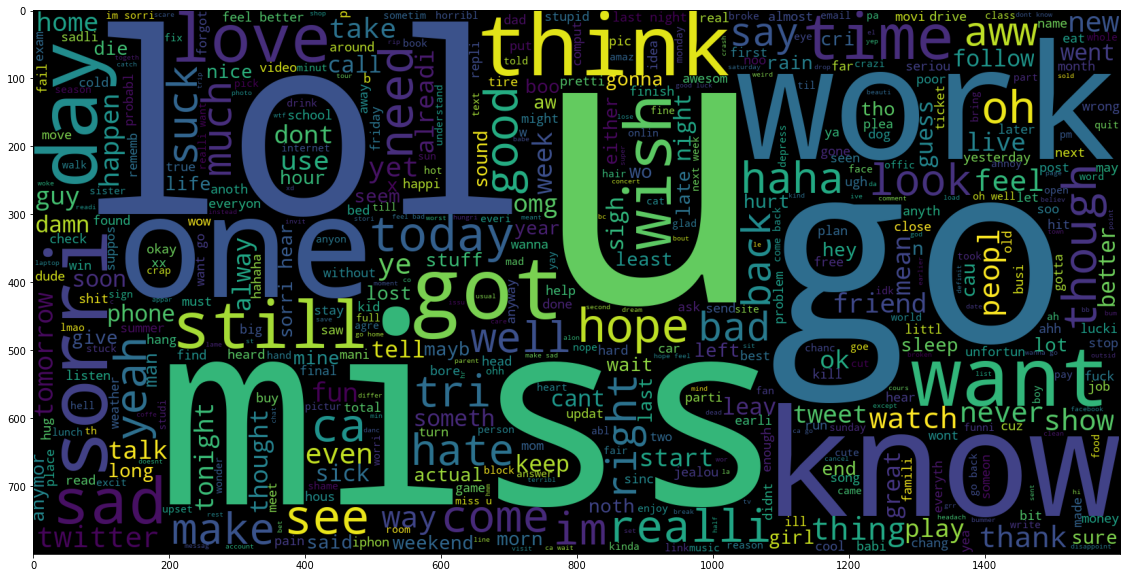

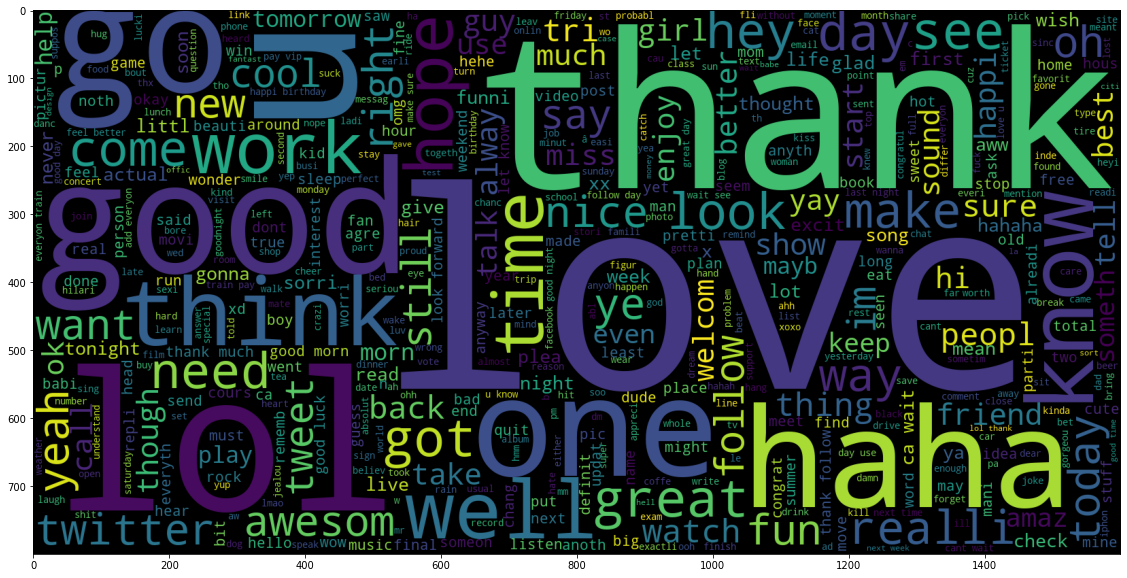

In [11]:
for sentiment_class in df['Sentiment'].dropna().unique():
    df_temp = df[df['Sentiment'] == sentiment_class]
    wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(' '.join(df_temp['SentimentText']))
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)

## Text vectorization: convert text into a numerical representation

In [12]:
vectorizer = TfidfVectorizer(
    min_df=2,            # ignore terms that have a document frequency strictly lower than 2
    ngram_range=(1, 1),  # (1, 2) for unigrams and bigrams
    max_features=10000)  # total number of words

# 9- Model construction: LogisticRegression

In [13]:
df.head()

,Sentiment,SentimentText
0,0.0,sad apl friend
1,0.0,miss new moon trailer
2,1.0,omg alreadi
3,0.0,omgaga im soo im gunna cri dentist sinc supos ...
4,0.0,think mi bf cheat t_t


## Train and test set

In [14]:
# Check that there are no duplicates before splitting
train, test = df[:len(df_train)], df[len(df_train):]
y_train = train['Sentiment']
X_train = train['SentimentText']
X_test = test['SentimentText']

## TF-IDF matrix (rows: tweets, columns: words)

In [15]:
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
print('No. of feature_words: ', len(vectorizer.get_feature_names()))
print(vectorizer.vocabulary_)
print(X_train)

No. of feature_words:  10000
{'sad': 7049, 'friend': 3066, 'miss': 5158, 'new': 5460, 'moon': 5240, 'trailer': 8737, 'omg': 5684, 'alreadi': 230, 'im': 3938, 'soo': 7715, 'gunna': 3448, 'cri': 1836, 'dentist': 2098, 'sinc': 7486, 'get': 3204, 'crown': 1855, 'put': 6487, 'min': 5135, 'think': 8469, 'mi': 5084, 'bf': 770, 'cheat': 1356, 't_t': 8249, 'worri': 9665, 'much': 5305, 'chillin': 1410, 'sunni': 8128, 'work': 9652, 'tomorrow': 8661, 'tv': 8865, 'tonight': 8671, 'hand': 3518, 'uniform': 9037, 'today': 8627, 'hmm': 3722, 'wonder': 9631, 'number': 5587, 'must': 5343, 'posit': 6270, 'thank': 8419, 'hater': 3564, 'face': 2744, 'day': 1994, 'weekend': 9430, 'suck': 8079, 'far': 2786, 'jb': 4207, 'isnt': 4123, 'show': 7410, 'australia': 490, 'ok': 5661, 'that': 8430, 'win': 9568, 'way': 9399, 'feel': 2832, 'right': 6882, 'awhh': 523, 'man': 4893, 'complet': 1631, 'useless': 9118, 'retweet': 6838, 'funni': 3115, 'twitter': 8903, 'strang': 8006, 'fine': 2881, 'gonna': 3302, 'go': 3285, 'l

## Tune model hyperparameters with Bayesian search

In [16]:
# define a search space
params = {
    'penalty': ['l1', 'l2'],
    'dual': [False],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    'max_iter': [1000]}
    
# instantiate the search, CV: the number of folds for the cross-validation, n_iter controls the number of searches
Bsearch = BayesSearchCV(LogisticRegression(), params, cv=5, scoring='f1_weighted', n_iter=5, random_state=5, verbose=True, error_score=0.0)

# fit the search with data
Bsearch.fit(X_train, y_train)

# examine the best model
print(Bsearch.best_score_)
print(Bsearch.best_params_)
print(Bsearch.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   52.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.9s finished


0.728056283301093
OrderedDict([('C', 0.1), ('dual', False), ('max_iter', 1000), ('penalty', 'l2'), ('solver', 'sag')])
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)


## Learning curve for various training set sizes

C:\Users\Sam\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0

  FitFailedWarning)


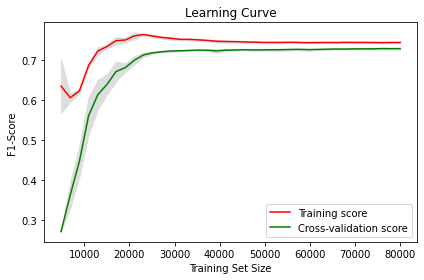

In [17]:
# Create CV training and test scores for various training set sizes (40 different sizes)
train_sizes, train_scores, test_scores = learning_curve(Bsearch.best_estimator_, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5, scoring='f1_weighted')

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, color='r', label='Training score')
plt.plot(train_sizes, test_mean, color='g', label='Cross-validation score')

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='#DDDDDD')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='#DDDDDD')

# Create plot
plt.title('Learning Curve')
plt.xlabel('Training Set Size'), plt.ylabel('F1-Score'), plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Train the model on the train set

In [18]:
model = Bsearch.best_estimator_.fit(X_train, y_train)

## Evaluate the model on the test set

In [19]:
predictions = model.predict(X_test).astype(np.int64)
df_submission = pd.DataFrame({'ItemID': df_test['ItemID'], 'Sentiment': predictions})
df_submission.to_csv(root + 'Sentiment_Analysis_predictions.csv', index=False)

## Feature importance